In [1]:
from datetime import timedelta

import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from matplotlib.colorbar import cm
import numpy as np
from tqdm.notebook import tqdm

In [2]:
def compute(df):
    cumulative_distribution_over_time = []
    total = len(df.index.get_level_values(0).categories)
    for source, group in tqdm(df.fastest.groupby(level=0), total=total):
        n_unique = group.reset_index(level=1).resample(pd.Timedelta(days=1), on='fastest', offset=-group.min()).target.nunique()
        cumulative_distribution_over_time += [n_unique.rename(source)]
    index = pd.timedelta_range(start=timedelta(weeks=0), end=timedelta(weeks=4), freq='D')
    return pd.concat(cumulative_distribution_over_time, axis=1).fillna(0).cumsum().reindex(index).ffill().astype(int)

In [3]:
microsoft = pd.read_pickle('../data/minimal_paths/microsoft.pickle')

In [4]:
ecdfs_over_time = compute(microsoft)

  0%|          | 0/37103 [00:00<?, ?it/s]

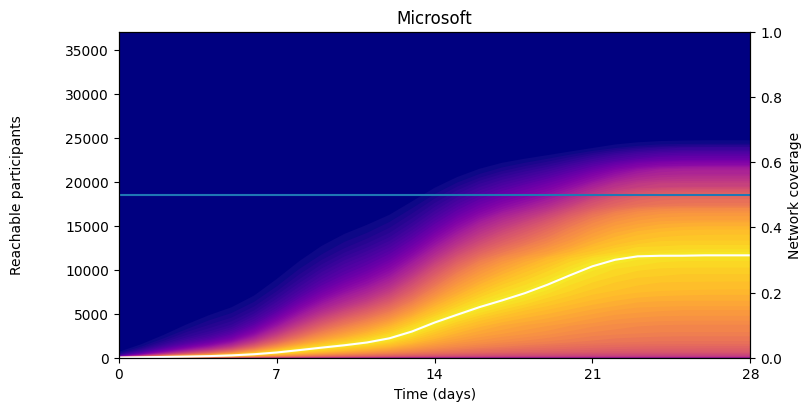

In [5]:
fig, ax = plt.subplots(figsize=(8, 4), constrained_layout=True, sharex=True, sharey=False)

df = ecdfs_over_time.reset_index(drop=True)
x = df.index

norm = cm.colors.Normalize(vmin=0.0, vmax=50)
q = np.column_stack((np.linspace(0.99, 0.51, 49), np.linspace(0.01, 0.49, 49)))
ax.fill_between(x=x, y1=0, y2=1, color=cm.plasma(norm(0)), edgecolor=None)
for c, (l,u) in enumerate(q):
    y1 = df.quantile(l, axis=1).rename(l)
    y2 = df.quantile(u, axis=1).rename(u)
    color = cm.plasma(norm(c))
    for_cbar = ax.fill_between(x=x, y1=y1, y2=y2, color=color, edgecolor=None)

df.median(axis=1).plot(ax=ax, color='white')

ax.set_xlim(0, df.index.max())
ax.set_ylim((0, df.shape[1]))
ax.set_facecolor(cm.jet(norm(0)))

ax.set_ylabel('Reachable participants')

ax.set_xticks([0, 7, 14, 21, 28])
ax.set_xticklabels([0, 7, 14, 21, 28])
ax.minorticks_off()
ax.set_title('Microsoft')

ax_m = ax.twinx() # mirror the x-axis
ax_m.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0]);
ax_m.set_ylabel('Network coverage')
ax.set_xlabel('Time (days)')

ax.yaxis.set_label_coords(-0.15, 0.5)
ax.axhline(df.shape[1]/2)
